In [18]:
!ls "./COGS 138 Encoding Decoding/data_NIX/"

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [19]:
# from google.colab import drive
# drive.mount('/content/drive')

In [20]:
import os
import h5py
import re
from h5py import Group
import pandas as pd

In [28]:
df1 = pd.read_h5(Data_Subject_01_Session_01.h5)

AttributeError: module 'pandas' has no attribute 'read_h5'

In [21]:
data_dir = r'/COGS 138 Encoding Decoding/data_NIX/'

subjects = {}  # dict of subject: DataFrame of iEEG data from trials

neutral_trials = ['01', '03', '05', '07', '09', '11', '13', '15', '17']
aversive_trials = ['02', '04', '06', '08', '10', '12', '14', '16']

In [27]:
iEEG_dir = r'/COGS 138 Encoding Decoding/iEEG data/'

subjects['01'] = pd.read_csv(iEEG_dir + 'subject_01_iEEG.csv')
subjects['01']

FileNotFoundError: [Errno 2] File /COGS 138 Encoding Decoding/iEEG data/subject_01_spiketimes.csv does not exist: '/COGS 138 Encoding Decoding/iEEG data/subject_01_spiketimes.csv'

In [ ]:
# Iterate through all subject data
for filename in os.listdir(data_dir):
  if filename.endswith('.h5'):
    # Retrieve data from file
    file = h5py.File(data_dir + filename, 'r')
    data = file['data']
    filename_tokens = re.split(r'[.]', filename)
    subject_session = filename_tokens[0]
    subject = data.get(subject_session)
    data_arrays = subject.get('data_arrays')

    # Get subject ID from filename
    subject_tokens = re.split(r'[_]', subject_session)
    subject_id = subject_tokens[2]
    print('Reading data for Subject', subject_id)

    df = None

    # Iterate through subject's trial data
    for key in data_arrays.keys():
      # Just handle iEEG data for now, TODO: spike time data
      if key.startswith('iEEG_Data'):
        # Is this trial neutral or aversive?
        # Encoding: neutral = 1, aversive = 2
        key_tokens = re.split(r'[_]', key)  # Stimulus_Condition_1_Neutral_Trial_13_iEEG
        print('Reading data for Trial', key_tokens[3])
        if key_tokens[3] in neutral_trials:
          condition = 1
        elif key_tokens[3] in aversive_trials:
          condition = 2
        else:
          condition = 0  # 0 indicates invalid condition

        iEEG_trial_data = pd.DataFrame(data_arrays.get(key)['data'])
        # For some reason, trials recording only one side list the data as
        # a column instead of a row (see Subject 03)
        if len(iEEG_trial_data) > 2:
          iEEG_trial_data = iEEG_trial_data.T
        
        iEEG_trial_data['condition'] = condition
        iEEG_trial_data['trial'] = key_tokens[3]

        if not isinstance(df, pd.DataFrame):
          df = iEEG_trial_data
        else:
          df = df.append(iEEG_trial_data, ignore_index=True)
      
      # temp break just to test data output
      # break
    
    subjects[subject_id] = df


Reading data for Subject 05
Reading data for Trial 01
Reading data for Trial 02
Reading data for Trial 03
Reading data for Trial 04
Reading data for Trial 05
Reading data for Trial 06
Reading data for Trial 07
Reading data for Trial 08
Reading data for Trial 09
Reading data for Trial 10
Reading data for Trial 11
Reading data for Trial 12
Reading data for Trial 13
Reading data for Trial 14
Reading data for Trial 15
Reading data for Trial 16
Reading data for Trial 17
Reading data for Subject 08
Reading data for Trial 01
Reading data for Trial 02
Reading data for Trial 03
Reading data for Trial 04
Reading data for Trial 05
Reading data for Trial 06
Reading data for Trial 07
Reading data for Trial 08
Reading data for Trial 09
Reading data for Trial 10
Reading data for Trial 11
Reading data for Trial 12
Reading data for Trial 13
Reading data for Trial 14
Reading data for Trial 15
Reading data for Trial 16
Reading data for Trial 17
Reading data for Subject 01
Reading data for Trial 01
Readin

In [ ]:
print(subjects['03'])
for id, df in subjects.items():
  df.to_csv('subject_' + id + '_iEEG.csv', index=False)

            0          1          2  ...      51999  condition  trial
0   -2.518554  -2.530844  -3.978066  ... -22.290791          1     01
1   -1.067843  -2.417430  -4.976071  ... -30.869889          2     02
2    4.653586   6.702972   9.894679  ... -37.623127          1     03
3  -33.227042 -48.012684 -43.971924  ...   5.666391          2     04
4  -68.928608 -99.199904 -88.131892  ... -34.166586          1     05
5   -7.721889  -9.682698 -10.280886  ... -25.644007          2     06
6  -18.067520 -24.716034 -21.070461  ... -33.058681          1     07
7   -4.021779  -4.669416  -4.517769  ...  21.306469          2     08
8    8.566430   7.990064   7.785990  ... -72.768066          1     09
9   21.276453  31.405796  31.063164  ...  -8.238045          2     10
10 -18.168823 -29.126791 -23.797598  ... -90.012787          1     11
11 -32.213702 -42.620994 -37.911130  ...  -5.561172          2     12
12 -31.108573 -47.142830 -40.638291  ...  22.532082          1     13
13 -34.965820 -48.79

In [8]:
!pip install neurodsp

     |████████████████████████████████| 92kB 5.9MB/s 


Condition 10    2
Name: condition, dtype: int64 Trial 10    6
Name: trial, dtype: int64


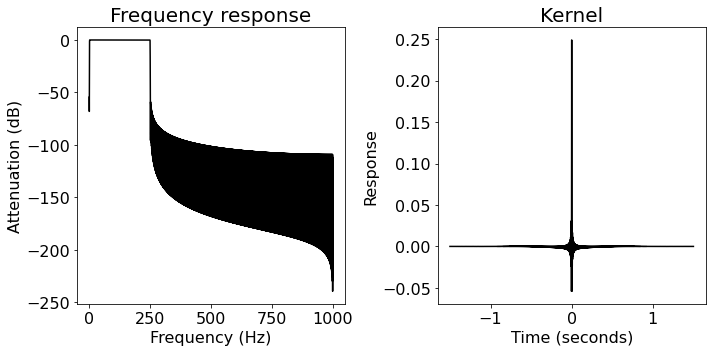

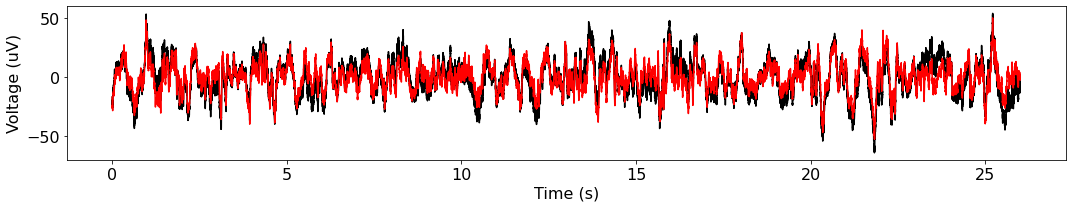

In [43]:
from neurodsp.plts import plot_time_series
from neurodsp.filt import filter_signal
import numpy as np

fs = 2000
sample = subjects['01'].sample(1)
print('Condition', sample['condition'], 'Trial', sample['trial'])
sample = sample.drop(['condition', 'trial'], axis=1).T
sample = np.array(sample).flatten()

filtered_sample = filter_signal(sample, fs, 'bandpass', (1, 250), remove_edges=False, plot_properties=True)
filtered_sample = filtered_sample - filtered_sample.mean()

times = np.arange(0, len(sample)/fs, 1/fs)
plot_time_series(times, [sample, filtered_sample])

(0.0, 10000.0)

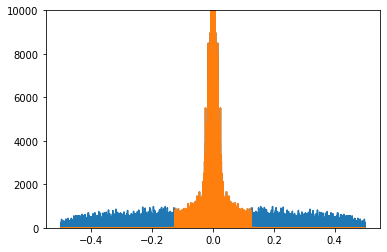

In [44]:
import matplotlib.pyplot as plt
import scipy.fft

freq = np.fft.fftfreq(times.shape[-1])

sample_fft = np.fft.fft(sample)
filtered_sample_fft = np.fft.fft(filtered_sample)
  
plt.plot(freq, sample_fft.real)
plt.plot(freq, filtered_sample_fft.real)
plt.ylim(0, 10000)

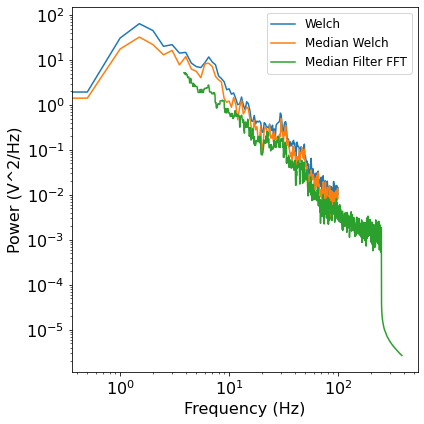

In [45]:
from neurodsp.spectral import compute_spectrum
from neurodsp.plts.spectral import plot_power_spectra

sig = filtered_sample

# Mean of spectrogram (Welch)
freq_mean, psd_mean = compute_spectrum(sig, fs, method='welch', avg_type='mean', nperseg=fs*2)

# Median of spectrogram ("median Welch")
freq_med, psd_med = compute_spectrum(sig, fs, method='welch', avg_type='median', nperseg=fs*2)

# Median filtered spectrum
freq_mf, psd_mf = compute_spectrum(sig, fs, method='medfilt')

plot_power_spectra([freq_mean[:200], freq_med[:200], freq_mf[100:10000]],
                   [psd_mean[:200], psd_med[:200], psd_mf[100:10000]],
                   ['Welch', 'Median Welch', 'Median Filter FFT'])

In [38]:
!pip install fooof

     |████████████████████████████████| 112kB 7.6MB/s 


[  2.96919749 126.22765404   2.56212874]


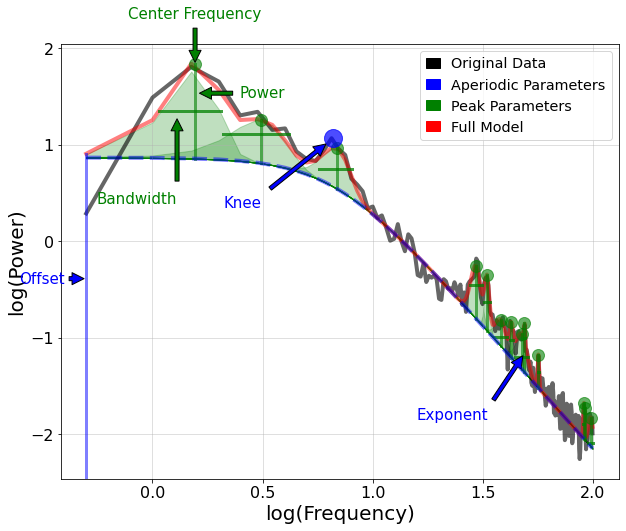

In [47]:
from fooof import FOOOF
from fooof.plts.annotate import plot_annotated_model

fm = FOOOF(min_peak_height=0.05, aperiodic_mode='knee', verbose=False)
fm.fit(freq_mean[:200], psd_mean[:200])
plot_annotated_model(fm, plt_log=True)
print(fm.aperiodic_params_)

<BarContainer object of 52000 artists>

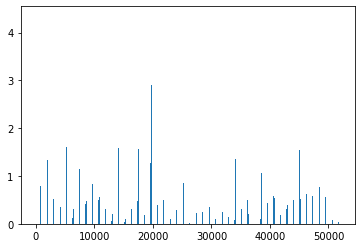

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

subject_query = '01'
X = subjects[subject_query].drop(['condition', 'trial'], axis=1)
y = subjects[subject_query].loc[:, 'condition']

X_indices = np.arange(X.shape[-1])

selector = SelectKBest(f_classif, k=5)
selector.fit(X, y)
scores = -np.log10(selector.pvalues_)
# scores /= scores.max()
plt.bar(X_indices - .45, scores, width=.2,
        label=r'Univariate score ($-Log(p_{value})$)')

In [50]:
params_df = pd.DataFrame(columns=['trial', 'condition', 'offset', 'knee', 'exponent'])

for idx, sample in subjects['01'].iterrows():
  condition = sample['condition']
  trial = sample['trial']
  print('Condition', sample['condition'], 'Trial', sample['trial'])
  sample = sample.drop(['condition', 'trial']).T
  sample = np.array(sample).flatten()

  filtered_sample = filter_signal(sample, fs, 'bandpass', (1, 250), remove_edges=False)
  filtered_sample = filtered_sample - filtered_sample.mean()

  # Mean of spectrogram (Welch)
  freq_mean, psd_mean = compute_spectrum(filtered_sample, fs, method='welch', avg_type='mean', nperseg=fs*2)

  fm = FOOOF(min_peak_height=0.05, aperiodic_mode='knee', verbose=False)
  fm.fit(freq_mean[:200], psd_mean[:200])

  params = fm.aperiodic_params_
  params_df = params_df.append({'trial': trial, 'condition': condition, 'offset': params[0], 'knee': params[1], 'exponent': params[2]}, ignore_index=True)

print(params_df)

Condition 1.0 Trial 1.0
Condition 1.0 Trial 1.0
Condition 2.0 Trial 2.0
Condition 2.0 Trial 2.0
Condition 1.0 Trial 3.0
Condition 1.0 Trial 3.0
Condition 2.0 Trial 4.0
Condition 2.0 Trial 4.0
Condition 1.0 Trial 5.0
Condition 1.0 Trial 5.0
Condition 2.0 Trial 6.0
Condition 2.0 Trial 6.0
Condition 1.0 Trial 7.0
Condition 1.0 Trial 7.0
Condition 2.0 Trial 8.0
Condition 2.0 Trial 8.0
Condition 1.0 Trial 9.0
Condition 1.0 Trial 9.0
Condition 2.0 Trial 10.0
Condition 2.0 Trial 10.0
Condition 1.0 Trial 11.0
Condition 1.0 Trial 11.0
Condition 2.0 Trial 12.0
Condition 2.0 Trial 12.0
Condition 1.0 Trial 13.0
Condition 1.0 Trial 13.0
Condition 2.0 Trial 14.0
Condition 2.0 Trial 14.0
Condition 1.0 Trial 15.0
Condition 1.0 Trial 15.0
Condition 2.0 Trial 16.0
Condition 2.0 Trial 16.0
Condition 1.0 Trial 17.0
Condition 1.0 Trial 17.0
    trial  condition    offset         knee  exponent
0     1.0        1.0  2.965672   143.223348  2.544711
1     1.0        1.0  2.886195    68.548501  2.262937
2     

In [54]:
params_df_neut = params_df.loc[params_df['condition'] == 1.0]
params_df_aver = params_df.loc[params_df['condition'] == 2.0]

print(params_df_neut.describe())
print(params_df_aver.describe())

           trial  condition     offset         knee   exponent
count  18.000000       18.0  18.000000    18.000000  18.000000
mean    9.000000        1.0   3.326560   630.936428   2.579441
std     5.313689        0.0   0.639098   955.230526   0.235304
min     1.000000        1.0   2.271904     9.088689   2.151186
25%     5.000000        1.0   2.906064    66.830524   2.433598
50%     9.000000        1.0   3.152549   133.326292   2.564802
75%    13.000000        1.0   4.041035   934.204286   2.770980
max    17.000000        1.0   4.270687  3312.909476   2.924684
           trial  condition     offset         knee   exponent
count  16.000000       16.0  16.000000    16.000000  16.000000
mean    9.000000        2.0   3.292724   426.900319   2.554083
std     4.732864        0.0   0.612623   392.237748   0.201151
min     2.000000        2.0   2.301426    17.539305   2.156794
25%     5.500000        2.0   2.679959    49.144262   2.385130
50%     9.000000        2.0   3.389939   347.913553   2

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


{'boxes': [<matplotlib.lines.Line2D at 0x7fd44cf036d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fd44cb20110>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fd44ce30250>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fd44ce30a10>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7fd44cf03750>,
  <matplotlib.lines.Line2D at 0x7fd44d0778d0>]}

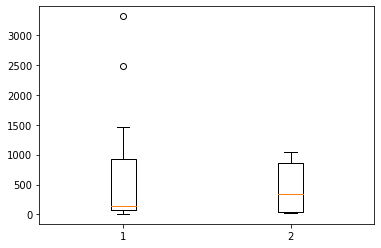

In [56]:
plt.boxplot([params_df_neut['knee'], params_df_aver['knee']])

In [53]:
params_df.to_csv('/content/drive/Shareddrives/COGS 138 Encoding Decoding/aperiodic_params.csv', index=False)

In [72]:
subjects_times = {}

for filename in os.listdir(data_dir):
  if filename.endswith('.h5'):
    # Retrieve data from file
    file = h5py.File(data_dir + filename, 'r')
    data = file['data']
    filename_tokens = re.split(r'[.]', filename)
    subject_session = filename_tokens[0]
    subject = data.get(subject_session)
    data_arrays = subject.get('data_arrays')

    # Get subject ID from filename
    subject_tokens = re.split(r'[_]', subject_session)
    subject_id = subject_tokens[2]
    print('Reading data for Subject', subject_id)

    df = None

    # Iterate through subject's trial data
    for key in data_arrays.keys():
      # Just handle spike time data
      if key.startswith('Spike_Times'):
        # Is this trial neutral or aversive?
        # Encoding: neutral = 1, aversive = 2
        key_tokens = re.split(r'[_]', key)  # Stimulus_Condition_1_Neutral_Trial_13_iEEG
        print('Reading data for Trial', key_tokens[3])
        if key_tokens[3] in neutral_trials:
          condition = 1
        elif key_tokens[3] in aversive_trials:
          condition = 2
        else:
          condition = 0  # 0 indicates invalid condition

        spike_times_data = pd.DataFrame(data_arrays.get(key)['data'])
        spike_times_data = spike_times_data.T
        
        spike_times_data['condition'] = condition
        spike_times_data['trial'] = key_tokens[3]

        if not isinstance(df, pd.DataFrame):
          df = spike_times_data
        else:
          df = df.append(spike_times_data, ignore_index=True)

        #break
      
      # temp break just to test data output
      # break
    
    subjects_times[subject_id] = df

Reading data for Subject 05
Reading data for Subject 08
Reading data for Subject 01
Reading data for Trial 1
Reading data for Trial 1
Reading data for Trial 1
Reading data for Trial 1
Reading data for Trial 1
Reading data for Trial 1
Reading data for Trial 1
Reading data for Trial 1
Reading data for Trial 1
Reading data for Trial 1
Reading data for Trial 1
Reading data for Trial 1
Reading data for Trial 1
Reading data for Trial 1
Reading data for Trial 1
Reading data for Trial 1
Reading data for Trial 1
Reading data for Trial 2
Reading data for Trial 2
Reading data for Trial 2
Reading data for Trial 2
Reading data for Trial 2
Reading data for Trial 2
Reading data for Trial 2
Reading data for Trial 2
Reading data for Trial 2
Reading data for Trial 2
Reading data for Trial 2
Reading data for Trial 2
Reading data for Trial 2
Reading data for Trial 2
Reading data for Trial 2
Reading data for Trial 2
Reading data for Trial 2
Reading data for Trial 3
Reading data for Trial 3
Reading data for

In [80]:
#print(subjects_times['05'])
for id, df in subjects_times.items():
  if df is None:
    print('skipping', id)
    continue
  df.to_csv('/content/drive/Shareddrives/COGS 138 Encoding Decoding/Spike Times/' + 'subject_' + id + '_spiketimes.csv', index=False)

skipping 05
skipping 08
skipping 06
skipping 09
